Let's see if we can create a model to predict if a coin will
1. go up by 1%
2. trade in the same zone
3. go down by 1%
in the next 2 hours (12 5m candles)

on CDC exchange, fees are 0.4% per transaction, so we should aim to make at least 0.2% profit on each trade

In [64]:
import json
from datetime import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from ta.momentum import RSIIndicator


from cdc_wrapper import CDC

In [3]:
with open('keys.json', 'r') as f:
    keys = json.load(f)

cdc = CDC(keys, sandbox=False)

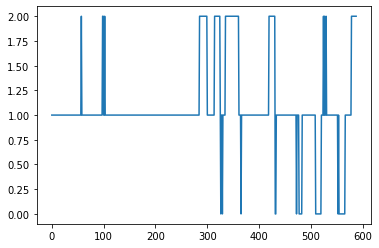

In [44]:
data = cdc.get_candlesticks('BTC_USDC', '5m', depth=1000)

df = pd.DataFrame.from_records(data)

future_window = 12
future_diff_threshold = 0.012

# convert our unix timestamp to dt
df['dt'] = pd.to_datetime(df['t'], unit='ms')

# calculate future values so we can set our labels
# will do feature engineering after this

future_cols = []
for i in range(1, future_window+1):
    df[f'h_{i}'] = df['h'].shift(-i)
    df[f'l_{i}'] = df['l'].shift(-i)
    future_cols.append(f'h_{i}')
    future_cols.append(f'l_{i}')

# drop the rows that will not have the full future values
df = df.iloc[:-future_window]

df['future_min'] = df.apply(lambda x: x[future_cols].min(), axis=1)
df['future_max'] = df.apply(lambda x: x[future_cols].max(), axis=1)

# can't think of how to decide if future_min came first or future_max came first
# so in the event that BOTH are more than 1% apart, will label as a "no difference"

df['min_flag'] = ((df['c'] - df['future_min']) / df['c']) > future_diff_threshold
df['max_flag'] = ((df['future_max'] - df['c']) / df['c']) > future_diff_threshold

df['label'] = 1
df.loc[(df['min_flag']==True)&(df['max_flag']==False), 'label'] = 0
df.loc[(df['min_flag']==False)&(df['max_flag']==True), 'label'] = 2
df.loc[(df['min_flag']==True)&(df['max_flag']==True), 'label'] = 1

df = df[['c', 'label']]

y = df['label'].values

plt.plot(y)

Let's focus on ETH USDC

In [66]:
data_file_name = 'data2.csv'
instrument = 'ETH_USDC'
future_window = 12
future_diff_threshold = 0.012
past_window = 24 # 2 hours?

# technical analysis params
rsi_windows = [5, 7]

# load in and drop duplicates
df = pd.read_csv(data_file_name).drop_duplicates()

# we are streaming data in through the websocket so we only need the latest row 
df = df.groupby(['instrument', 't']).last().reset_index()

# filter for ETH USDC
df = df.loc[df['instrument']==instrument]

# convert our unix timestamp to dt
df['dt'] = pd.to_datetime(df['t'], unit='ms')

# calculate future values so we can set our labels
# will do feature engineering after this

future_cols = []
for i in range(1, future_window+1):
    df[f'h_{i}'] = df['h'].shift(-i)
    df[f'l_{i}'] = df['l'].shift(-i)
    future_cols.append(f'h_{i}')
    future_cols.append(f'l_{i}')

# drop the rows that will not have the full future values
df = df.iloc[:-future_window]

df['future_min'] = df.apply(lambda x: x[future_cols].min(), axis=1)
df['future_max'] = df.apply(lambda x: x[future_cols].max(), axis=1)

# can't think of how to decide if future_min came first or future_max came first
# so in the event that BOTH are more than 1% apart, will label as a "no difference"

df['min_flag'] = ((df['c'] - df['future_min']) / df['c']) > future_diff_threshold
df['max_flag'] = ((df['future_max'] - df['c']) / df['c']) > future_diff_threshold

df['label'] = 0
df.loc[(df['min_flag']==True)&(df['max_flag']==False), 'label'] = 1
df.loc[(df['min_flag']==False)&(df['max_flag']==True), 'label'] = 2
df.loc[(df['min_flag']==True)&(df['max_flag']==True), 'label'] = 0

# now that we have the labels, we can remove the future values and clean up a bit...

df = df[['dt', 'o', 'h', 'l', 'c', 'v', 'label']]

df = df.set_index('dt')

for w in rsi_windows:
    df[f'rsi{w}'] = RSIIndicator(df['c'], window=w).rsi()

df
# # let's bring in the past values
# for i in range(1, past_window+1):
#     df[f'o_{i}'] = df['o'].shift(i)
#     df[f'h_{i}'] = df['h'].shift(i)
#     df[f'l_{i}'] = df['l'].shift(i)
#     df[f'c_{i}'] = df['c'].shift(i)
#     df[f'v_{i}'] = df['v'].shift(i)

# # drop those without past data
# df = df.iloc[past_window:]

# scaler = MinMaxScaler()
# X = df.drop(['dt', 'label'], axis=1).values
# y = df['label'].values

# scaler.fit(X)

# scaler.transform(X)

,o,h,l,c,v,label,rsi5,rsi7
dt,,,,,,,,
2022-07-09 05:35:00,1213.73,1214.82,1211.10,1211.35,0.43450,0,NaN,NaN
2022-07-09 05:40:00,1211.10,1215.13,1211.10,1212.46,0.01794,0,NaN,NaN
2022-07-09 05:45:00,1212.83,1213.58,1211.12,1213.34,5.13657,0,NaN,NaN
2022-07-09 05:50:00,1213.52,1213.64,1211.82,1211.89,1.45837,0,NaN,NaN
2022-07-09 05:55:00,1212.87,1214.97,1212.71,1213.69,0.69837,0,71.648678,NaN
2022-07-09 06:00:00,1213.93,1214.83,1212.97,1213.51,2.57917,0,67.913968,NaN
2022-07-09 06:05:00,1213.40,1214.84,1212.94,1214.84,0.77179,0,78.341253,77.329833
2022-07-09 06:10:00,1214.60,1215.74,1214.17,1214.21,0.37980,0,65.699282,66.888329
2022-07-09 06:15:00,1214.34,1215.35,1213.41,1215.10,2.35241,0,73.306001,72.915722


In [61]:
test_scaler = MinMaxScaler()



test_scaler.fit(df[['o', 'h', 'l', 'c', 'v']].values)

# test_scaler.data_min_ = 0
# test_scaler.data_max_ = 6000

test_scaler.transform(df[['o', 'h', 'l', 'c', 'v']].values)


array([[0.28153153, 0.23970533, 0.33077746, 0.28523924, 0.01552615],
       [0.27571321, 0.30751794, 0.35520685, 0.35082209, 0.04847423],
       [0.34853604, 0.32338496, 0.40656205, 0.34121559, 0.01160411],
       [0.33164414, 0.30525123, 0.38605563, 0.34564936, 0.06344138],
       [0.31831832, 0.27691726, 0.35217546, 0.31627563, 0.01929242],
       [0.31437688, 0.44956555, 0.36055635, 0.47699982, 0.13261395],
       [0.47597598, 0.53022289, 0.53815977, 0.57620543, 0.39885017],
       [0.56456456, 0.55987911, 0.59950071, 0.55440606, 0.06039235],
       [0.55292793, 0.51718927, 0.59201141, 0.53944208, 0.01346045],
       [0.54091592, 0.50321118, 0.58042083, 0.54812488, 0.04497732],
       [0.53828829, 0.50585569, 0.58594864, 0.52724921, 0.01306362],
       [0.52045796, 0.47619947, 0.52104137, 0.47884722, 0.03766112],
       [0.47222222, 0.42765395, 0.44828816, 0.41030852, 0.07625983],
       [0.40221471, 0.36683037, 0.38534237, 0.34343248, 0.19038368],
       [0.34346847, 0.32395164, 0.

check if the min or max of the next 12 5 minute candles are either 1.5% higher or lower